In [21]:
!pip install sklearn

In [22]:
%matplotlib inline

In [1]:
!pip install tensorflow


# Recognizing hand-written digits

This example shows how scikit-learn can be used to recognize images of
hand-written digits, from 0-9.


In [2]:
# Author: Gael Varoquaux <gael dot varoquaux at normalesup dot org>
# License: BSD 3 clause

# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'sklearn'

In [1]:
import numpy as np
import pickle
from ctypes import *
from numpy.ctypeslib import ndpointer
import tensorflow as tf
from qmcpy import *

m = 10
nu = 3

Ndata = 60000
Nqmc = 2**m;

# load mnist data and rescale to 10x10
mnist = tf.keras.datasets.mnist

2022-09-24 10:55:13.999758: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-24 10:55:13.999780: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()


In [2]:
train_labels


NameError: name 'train_labels' is not defined

* What was discussed0
    * Figured out how they propose to change the RMSE to change the data computations
    * Actually computes the neural network in C….
    * Steps to compile and reproduce Examples 1 and 2 in QMCPy’s ml_train_and_compress branch (SC’s request)
* Next meeting: 10am Oct 15, Sat


In [13]:
len(train_labels)

60000

In [ ]:
import numpy as np
import pickle
from ctypes import *
from numpy.ctypeslib import ndpointer
import tensorflow as tf
from qmcpy import *

m = 10
nu = 3

Ndata = 60000
Nqmc = 2**m;

# load mnist data and rescale to 10x10
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train =  np.float64(tf.one_hot(y_train,10).numpy())


x_train= x_train[:Ndata,:,:]
y_train = y_train[:Ndata]

x_train = x_train[...,tf.newaxis]
x_train = tf.image.resize(x_train,[10,10])
x_train = x_train.numpy()[:,:,:,0]


# data dimension
Ndata=x_train.shape[0]
s=x_train.shape[1]*x_train.shape[2]
outs = y_train.shape[1]

# flatten 10x10 to 100x1 for weight computation
x_train_flat = np.float64(0.99*np.transpose(x_train.reshape(x_train.shape[0],s)))

# load qmc points
#dig_net = DigitalNetB2(2,seed=6)
#qmc_points_gen = np.array(dig_net.gen_samples(Nqmc), dtype=np.ndarray)
qmc_points = np.loadtxt('sobol.dat')
#breakpoint()
qmc_points = qmc_points[0:Nqmc,0:s]


print(qmc_points.shape)
print(x_train_flat.shape)

# load c functions 
lib = cdll.LoadLibrary("/Users/r2q2/Projects/QMCSoftware/qmcpy/machine_learning/c_lib/computeMXY.so")
computeWeights = lib.computeWeights
computeWeights.restype=ndpointer(dtype=c_double,shape=(1+outs,Nqmc))
print('Weights loaded')

# compute weights
weights = computeWeights(c_int(nu),
                         c_int(m),
                         c_int(s),
                         c_int(Ndata),
                         c_int(Nqmc),
                         c_int(outs),
                         c_void_p(x_train_flat.ctypes.data),
                         c_void_p(qmc_points.ctypes.data),c_void_p(y_train.ctypes.data))
weights = np.transpose(weights)

#breakpoint()
print(weights.shape)
with open('weights.pkl', 'wb') as handle:
    pickle.dump(weights, handle, protocol=pickle.HIGHEST_PROTOCOL)
    


(1024, 100)
(100, 60000)
Weights loaded


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(10)
])

In [26]:
weights[0]

array([0.04247682, 0.00419723, 0.00481732, 0.00424134, 0.00429414,
       0.0041096 , 0.00387474, 0.00418268, 0.00445003, 0.00414186,
       0.00416787])

In [7]:
weights

array([[ 4.24768229e-02,  4.19723307e-03,  4.81731771e-03, ...,
         4.45003255e-03,  4.14186198e-03,  4.16787109e-03],
       [ 5.15690104e-04,  4.71354167e-05,  6.29557292e-05, ...,
         4.78515625e-05,  5.50455729e-05,  4.45312500e-05],
       [-5.51979167e-03, -5.43587240e-04, -6.30794271e-04, ...,
        -5.81933594e-04, -5.44856771e-04, -5.38509115e-04],
       ...,
       [ 1.36093750e-03,  1.37955729e-04,  1.52929688e-04, ...,
         1.41731771e-04,  1.38313802e-04,  1.35872396e-04],
       [-2.21803385e-03, -2.18326823e-04, -2.69856771e-04, ...,
        -2.38769531e-04, -2.12695312e-04, -2.16894531e-04],
       [ 2.44114583e-03,  2.51106771e-04,  2.73437500e-04, ...,
         2.50716146e-04,  2.41634115e-04,  2.43229167e-04]])

In [15]:
from sklearn.cluster import KMeans
import numpy as np
#X = np.array([[1, 2], [1, 4], [1, 0],              [10, 2], [10, 4], [10, 0]])
kmeans = KMeans(n_clusters=11, random_state=0).fit(weights)
kmeans.labels_

#kmeans.predict([[0, 0], [12, 3]])

kmeans.cluster_centers_

#kmeans.labels_array([1, 2, 3, 4, 5, 6, 7 ,8 , 9 , 0], dtype=int32)


array([[ 5.62449511e-04,  5.51458865e-05,  6.32687606e-05,
         5.61572598e-05,  5.80993569e-05,  5.44386426e-05,
         5.08993676e-05,  5.53369473e-05,  5.88913690e-05,
         5.45778858e-05,  5.56340349e-05],
       [ 5.21740885e-03,  5.14790251e-04,  5.90131341e-04,
         5.19727129e-04,  5.27989697e-04,  5.05833616e-04,
         4.73468637e-04,  5.14485960e-04,  5.46916044e-04,
         5.10293252e-04,  5.13772928e-04],
       [ 2.33680013e-02,  2.31141764e-03,  2.65014648e-03,
         2.33517253e-03,  2.36344401e-03,  2.26146647e-03,
         2.13494466e-03,  2.30260417e-03,  2.44449056e-03,
         2.27423503e-03,  2.29007975e-03],
       [-7.43334993e-03, -7.34199474e-04, -8.45186121e-04,
        -7.41203278e-04, -7.51012306e-04, -7.17591529e-04,
        -6.77937347e-04, -7.30644914e-04, -7.80934053e-04,
        -7.26115707e-04, -7.28525199e-04],
       [ 1.59628635e-02,  1.57664388e-03,  1.81056586e-03,
         1.59500868e-03,  1.61448568e-03,  1.54403483e-03,
  

In [18]:
len(kmeans.labels_)

1024

In [14]:
to_predict = array[0.04247682, 0.00419723, 0.00481732, 0.00424134, 0.00429414,
       0.0041096 , 0.00387474, 0.00418268, 0.00445003, 0.00414186,
       0.00416787].reshape(-1, 1)


TypeError: 'module' object is not subscriptable

In [ ]:
#kmeans.predict([[0, 0], [12, 3]]) array([1, 0], dtype=int32)
#kmeans.cluster_centers_array([[10.,  2.],[ 1.,  2.]])

In [ ]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
y = np.array([1, 1, 2, 2])
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, y)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [25]:
weights

array([[ 4.24768229e-02,  4.19723307e-03,  4.81731771e-03, ...,
         4.45003255e-03,  4.14186198e-03,  4.16787109e-03],
       [ 5.15690104e-04,  4.71354167e-05,  6.29557292e-05, ...,
         4.78515625e-05,  5.50455729e-05,  4.45312500e-05],
       [-5.51979167e-03, -5.43587240e-04, -6.30794271e-04, ...,
        -5.81933594e-04, -5.44856771e-04, -5.38509115e-04],
       ...,
       [ 1.36093750e-03,  1.37955729e-04,  1.52929688e-04, ...,
         1.41731771e-04,  1.38313802e-04,  1.35872396e-04],
       [-2.21803385e-03, -2.18326823e-04, -2.69856771e-04, ...,
        -2.38769531e-04, -2.12695312e-04, -2.16894531e-04],
       [ 2.44114583e-03,  2.51106771e-04,  2.73437500e-04, ...,
         2.50716146e-04,  2.41634115e-04,  2.43229167e-04]])

In [ ]:
# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False
)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)

In [18]:
digits.images

array([[[ 0.,  0.,  5., ...,  1.,  0.,  0.],
        [ 0.,  0., 13., ..., 15.,  5.,  0.],
        [ 0.,  3., 15., ..., 11.,  8.,  0.],
        ...,
        [ 0.,  4., 11., ..., 12.,  7.,  0.],
        [ 0.,  2., 14., ..., 12.,  0.,  0.],
        [ 0.,  0.,  6., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  5.,  0.,  0.],
        [ 0.,  0.,  0., ...,  9.,  0.,  0.],
        [ 0.,  0.,  3., ...,  6.,  0.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., 12.,  0.,  0.],
        [ 0.,  0.,  3., ..., 14.,  0.,  0.],
        [ 0.,  0.,  8., ..., 16.,  0.,  0.],
        ...,
        [ 0.,  9., 16., ...,  0.,  0.,  0.],
        [ 0.,  3., 13., ..., 11.,  5.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.]],

       ...,

       [[ 0.,  0.,  1., ...,  1.,  0.,  0.],
        [ 0.,  0., 13., ...,  2.,  1.,  0.],
        [ 0.,  0., 16., ..., 16.,  5.,  0.

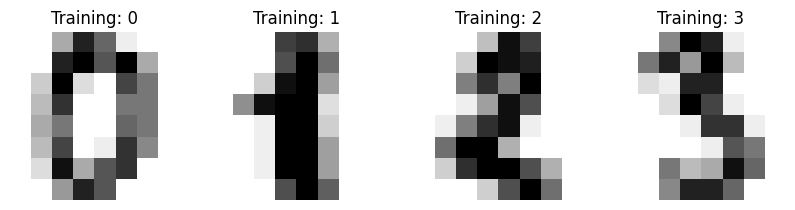

In [16]:
#lenweights[0]
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [ ]:
# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    weights, digits.target, test_size=0.5, shuffle=False
)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)

## Digits dataset

The digits dataset consists of 8x8
pixel images of digits. The ``images`` attribute of the dataset stores
8x8 arrays of grayscale values for each image. We will use these arrays to
visualize the first 4 images. The ``target`` attribute of the dataset stores
the digit each image represents and this is included in the title of the 4
plots below.

Note: if we were working from image files (e.g., 'png' files), we would load
them using :func:`matplotlib.pyplot.imread`.



In [11]:
x_train[0]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.80392165e-02, 6.00784361e-01,
        8.45686197e-01, 9.92156863e-01, 7.32941628e-01, 6.20588243e-01,
        8.78432393e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.99764597e-01,
        9.59804058e-01, 3.01961787e-03, 1.26823992e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.14627624e-01, 8.99997428e-02, 1.17646836e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
   

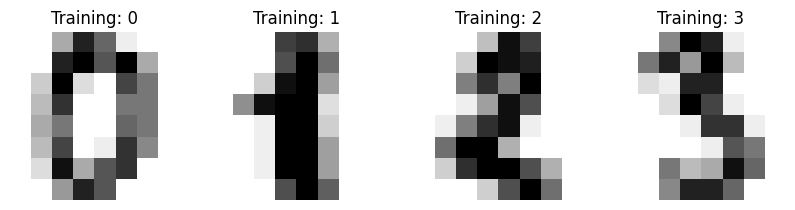

In [6]:
digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [15]:
digits[0]

KeyError: 0

## Classification

To apply a classifier on this data, we need to flatten the images, turning
each 2-D array of grayscale values from shape ``(8, 8)`` into shape
``(64,)``. Subsequently, the entire dataset will be of shape
``(n_samples, n_features)``, where ``n_samples`` is the number of images and
``n_features`` is the total number of pixels in each image.

We can then split the data into train and test subsets and fit a support
vector classifier on the train samples. The fitted classifier can
subsequently be used to predict the value of the digit for the samples
in the test subset.



In [ ]:
# flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False
)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)

Below we visualize the first 4 test samples and show their predicted
digit value in the title.



In [ ]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, predicted):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Prediction: {prediction}")

:func:`~sklearn.metrics.classification_report` builds a text report showing
the main classification metrics.



In [ ]:
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

We can also plot a `confusion matrix <confusion_matrix>` of the
true digit values and the predicted digit values.



In [ ]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()